# PET Challenge 2025 — Approach Comparison

## Two Scoring Approaches

| Aspect | Conservation (MSA + Table S6) | ESM PLM (Zero-Shot) |
|--------|-------------------------------|---------------------|
| **Method** | Penalize mutations at conserved positions | ESM2 log-likelihood ratio per mutation |
| **Compute** | CPU-only, ~1 min (MAFFT) | GPU required, ~30 min (ESM2-650M) |
| **Biological prior** | Conservation = function | Evolutionary plausibility |
| **Notebook** | `Conservation_Scoring_Pipeline.ipynb` | `PET_Challenge_2025_Pipeline_v2.ipynb` |
| **Output** | `results/submission_conservation.csv` | `results/submission_zero_shot_v5.csv` |

## Evaluation Strategy

Since ground truth is unavailable before the competition deadline, we evaluate using:

1. **Inter-approach agreement** — Spearman/Kendall correlation, top-K overlap, rank-rank plots
2. **WT vs mutant separation** — Cohen's d, Mann-Whitney AUC (WT should score higher on average)
3. **IsPETase validation** — 10 single-point mutants with experimental delta-Tm (Son 2019)
4. **Score distribution quality** — entropy, spread, discrimination capacity
5. **Ensemble exploration** — alpha-sweep to find optimal blending

**Competition metric:** NDCG (rank-based) — so rank-order quality is what matters most.


In [2]:
# Set project root - handles Colab's /content/ path automatically
# If running from within the cloned repo:
if os.path.exists('data/petase_challenge_data'):
    PROJECT_ROOT = os.getcwd()
elif os.path.exists('pet-challenge-2025/data/petase_challenge_data'):
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)
elif os.path.exists('/content/pet-challenge-2025/data/petase_challenge_data'):
    # Google Colab default clone location
    PROJECT_ROOT = '/content/pet-challenge-2025'
    os.chdir(PROJECT_ROOT)
else:
    # Clone the repo
    !git clone https://github.com/fulopjoz/pet-challenge-2025.git
    # Pin to specific commit for reproducibility:
    # !git checkout <COMMIT_HASH>  # fill in after final commit
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)

print(f"Project root: {PROJECT_ROOT}")
print(f"Working dir:  {os.getcwd()}")

# Verify ALL required files exist
required_files = [
    'data/petase_challenge_data/pet-2025-wildtype-cds.csv',
    'data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv',
    'data/mutations_dataset.csv',
    'data/features_matrix.csv',
    'scripts/esm2_zero_shot_scoring.py',
    'scripts/esmc_scoring.py',
    'scripts/compute_cds_features.py',
    'scripts/generate_submission.py',
    'scripts/generate_submission_v2.py',
    'scripts/validate_scores.py',
]
all_ok = True
for f in required_files:
    path = os.path.join(PROJECT_ROOT, f)
    if os.path.exists(path):
        size_kb = os.path.getsize(path) / 1024
        print(f"  OK: {f} ({size_kb:.0f} KB)")
    else:
        print(f"  MISSING: {f}")
        all_ok = False

if all_ok:
    print("\nAll files present!")
else:
    print("\nSome files missing - check your clone or upload")

# Make results directory
os.makedirs(os.path.join(PROJECT_ROOT, 'results'), exist_ok=True)

# pKa usage controls for submission generation section
USE_PKA = True
STRICT_PKA = True
print(f"pKa config: USE_PKA={USE_PKA}, STRICT_PKA={STRICT_PKA}")


Cloning into 'pet-challenge-2025'...
remote: Enumerating objects: 349, done.
remote: Counting objects: 100% (349/349), done.
remote: Compressing objects: 100% (263/263), done.
remote: Total 349 (delta 176), reused 257 (delta 85), pack-reused 0 (from 0)
Receiving objects: 100% (349/349), 9.77 MiB | 9.28 MiB/s, done.
Resolving deltas: 100% (176/176), done.
Project root: /content/pet-challenge-2025
Working dir:  /content/pet-challenge-2025
  OK: data/petase_challenge_data/pet-2025-wildtype-cds.csv (302 KB)
  OK: data/petase_challenge_data/predictive-pet-zero-shot-test-2025.csv (1274 KB)
  OK: data/mutations_dataset.csv (6 KB)
  OK: data/features_matrix.csv (19 KB)
  OK: scripts/esm2_zero_shot_scoring.py (17 KB)
  OK: scripts/esmc_scoring.py (14 KB)
  OK: scripts/compute_cds_features.py (11 KB)
  OK: scripts/generate_submission.py (9 KB)
  OK: scripts/generate_submission_v2.py (33 KB)
  OK: scripts/validate_scores.py (13 KB)

All files present!
pKa config: USE_PKA=True, STRICT_PKA=True


In [3]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from scipy.spatial.distance import jensenshannon
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
matplotlib.rcParams.update({'font.size': 11, 'figure.dpi': 120})

# Paths — detect project root (works in Colab, VS Code, and local)
if os.path.exists('data/petase_challenge_data'):
    PROJECT_ROOT = os.getcwd()
elif os.path.exists('pet-challenge-2025/data/petase_challenge_data'):
    PROJECT_ROOT = os.path.join(os.getcwd(), 'pet-challenge-2025')
    os.chdir(PROJECT_ROOT)
elif os.path.exists('/content/pet-challenge-2025/data/petase_challenge_data'):
    PROJECT_ROOT = '/content/pet-challenge-2025'
    os.chdir(PROJECT_ROOT)
else:
    raise FileNotFoundError(
        'Cannot find data/petase_challenge_data/. '
        'Run this notebook from the repo root or clone first.'
    )
DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'petase_challenge_data')
RESULTS_DIR = os.path.join(PROJECT_ROOT, 'results')

CONS_CSV   = os.path.join(RESULTS_DIR, 'submission_conservation.csv')
ESM_V4_CSV = os.path.join(RESULTS_DIR, 'submission_zero_shot_v4.csv')
ESM_CSV    = os.path.join(RESULTS_DIR, 'submission_zero_shot_v5.csv')
WT_CSV     = os.path.join(DATA_DIR, 'pet-2025-wildtype-cds.csv')
TEST_CSV   = os.path.join(DATA_DIR, 'predictive-pet-zero-shot-test-2025.csv')
FEAT_CSV   = os.path.join(PROJECT_ROOT, 'data', 'features_matrix.csv')
MUT_CSV    = os.path.join(PROJECT_ROOT, 'data', 'mutations_dataset.csv')

# Target columns (short aliases)
TARGETS = {
    'act1': 'activity_1 (\u03bcmol [TPA]/min\u00b7mg [E])',
    'act2': 'activity_2 (\u03bcmol [TPA]/min\u00b7mg [E])',
    'expr': 'expression (mg/mL)',
}
TARGET_RANGES = {'act1': (0, 5), 'act2': (0, 5), 'expr': (0, 3)}
TARGET_LABELS = {'act1': 'Activity 1 (pH 5.5)', 'act2': 'Activity 2 (pH 9.0)', 'expr': 'Expression'}

print("Approach Comparison Notebook \u2014 PET Challenge 2025")
print(f"Project root: {PROJECT_ROOT}")

Approach Comparison Notebook — PET Challenge 2025
Project root: /content/pet-challenge-2025


In [4]:
# --- File existence checks ---
cons_available = os.path.exists(CONS_CSV)
esm_v4_available = os.path.exists(ESM_V4_CSV)
esm_v5_available = os.path.exists(ESM_CSV)
esm_available = esm_v4_available or esm_v5_available  # backward compat flag

print(f"Conservation submission: {'FOUND' if cons_available else 'MISSING'} \u2014 {CONS_CSV}")
print(f"ESM v4 submission:       {'FOUND' if esm_v4_available else 'MISSING'} \u2014 {ESM_V4_CSV}")
print(f"ESM v5 submission:       {'FOUND' if esm_v5_available else 'MISSING'} \u2014 {ESM_CSV}")

if not cons_available:
    raise FileNotFoundError("Conservation submission is required. Run Conservation_Scoring_Pipeline first.")

# --- Load submissions ---
cons = pd.read_csv(CONS_CSV)
print(f"\nConservation: {len(cons)} sequences, columns: {list(cons.columns)}")

submissions = {'Conservation': cons}

if esm_v4_available:
    esm_v4 = pd.read_csv(ESM_V4_CSV)
    print(f"ESM v4:       {len(esm_v4)} sequences, columns: {list(esm_v4.columns)}")
    assert list(cons['sequence']) == list(esm_v4['sequence']), \
        "Sequence order mismatch between Conservation and ESM v4!"
    submissions['ESM v4'] = esm_v4
else:
    esm_v4 = None

if esm_v5_available:
    esm_v5 = pd.read_csv(ESM_CSV)
    print(f"ESM v5:       {len(esm_v5)} sequences, columns: {list(esm_v5.columns)}")
    assert list(cons['sequence']) == list(esm_v5['sequence']), \
        "Sequence order mismatch between Conservation and ESM v5!"
    submissions['ESM v5'] = esm_v5
else:
    esm_v5 = None

# Backward compat: 'esm' points to latest available ESM version
esm = esm_v5 if esm_v5_available else esm_v4

if esm_available:
    print(f"\nSequence order: MATCHED across {len(submissions)} submissions")
else:
    print("\nNo ESM submissions found \u2014 comparison cells will show conservation-only analysis.")
    print("To enable full comparison, copy submission_zero_shot_v4/v5.csv to results/")

print(f"Active submissions: {list(submissions.keys())}")

# --- Load WT sequences for WT/mutant classification ---
wt_df = pd.read_csv(WT_CSV)
wt_set = set(wt_df['Wt AA Sequence'].values)
print(f"\nWT scaffolds loaded: {len(wt_set)}")

is_wt = cons['sequence'].isin(wt_set).values
n_wt = is_wt.sum()
n_mut = (~is_wt).sum()
print(f"Test set: {n_wt} WT sequences, {n_mut} mutant sequences")
print(f"WT fraction: {n_wt/len(cons)*100:.1f}%")

Conservation submission: FOUND — /content/pet-challenge-2025/results/submission_conservation.csv
ESM v4 submission:       FOUND — /content/pet-challenge-2025/results/submission_zero_shot_v4.csv
ESM v5 submission:       FOUND — /content/pet-challenge-2025/results/submission_zero_shot_v5.csv

Conservation: 4988 sequences, columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']
ESM v4:       4988 sequences, columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']
ESM v5:       4988 sequences, columns: ['sequence', 'activity_1 (μmol [TPA]/min·mg [E])', 'activity_2 (μmol [TPA]/min·mg [E])', 'expression (mg/mL)']

Sequence order: MATCHED across 3 submissions
Active submissions: ['Conservation', 'ESM v4', 'ESM v5']

WT scaffolds loaded: 313
Test set: 314 WT sequences, 4674 mutant sequences
WT fraction: 6.3%


## 1. Submission-Level Comparison

Direct comparison of the two approaches on the 4988 test sequences.


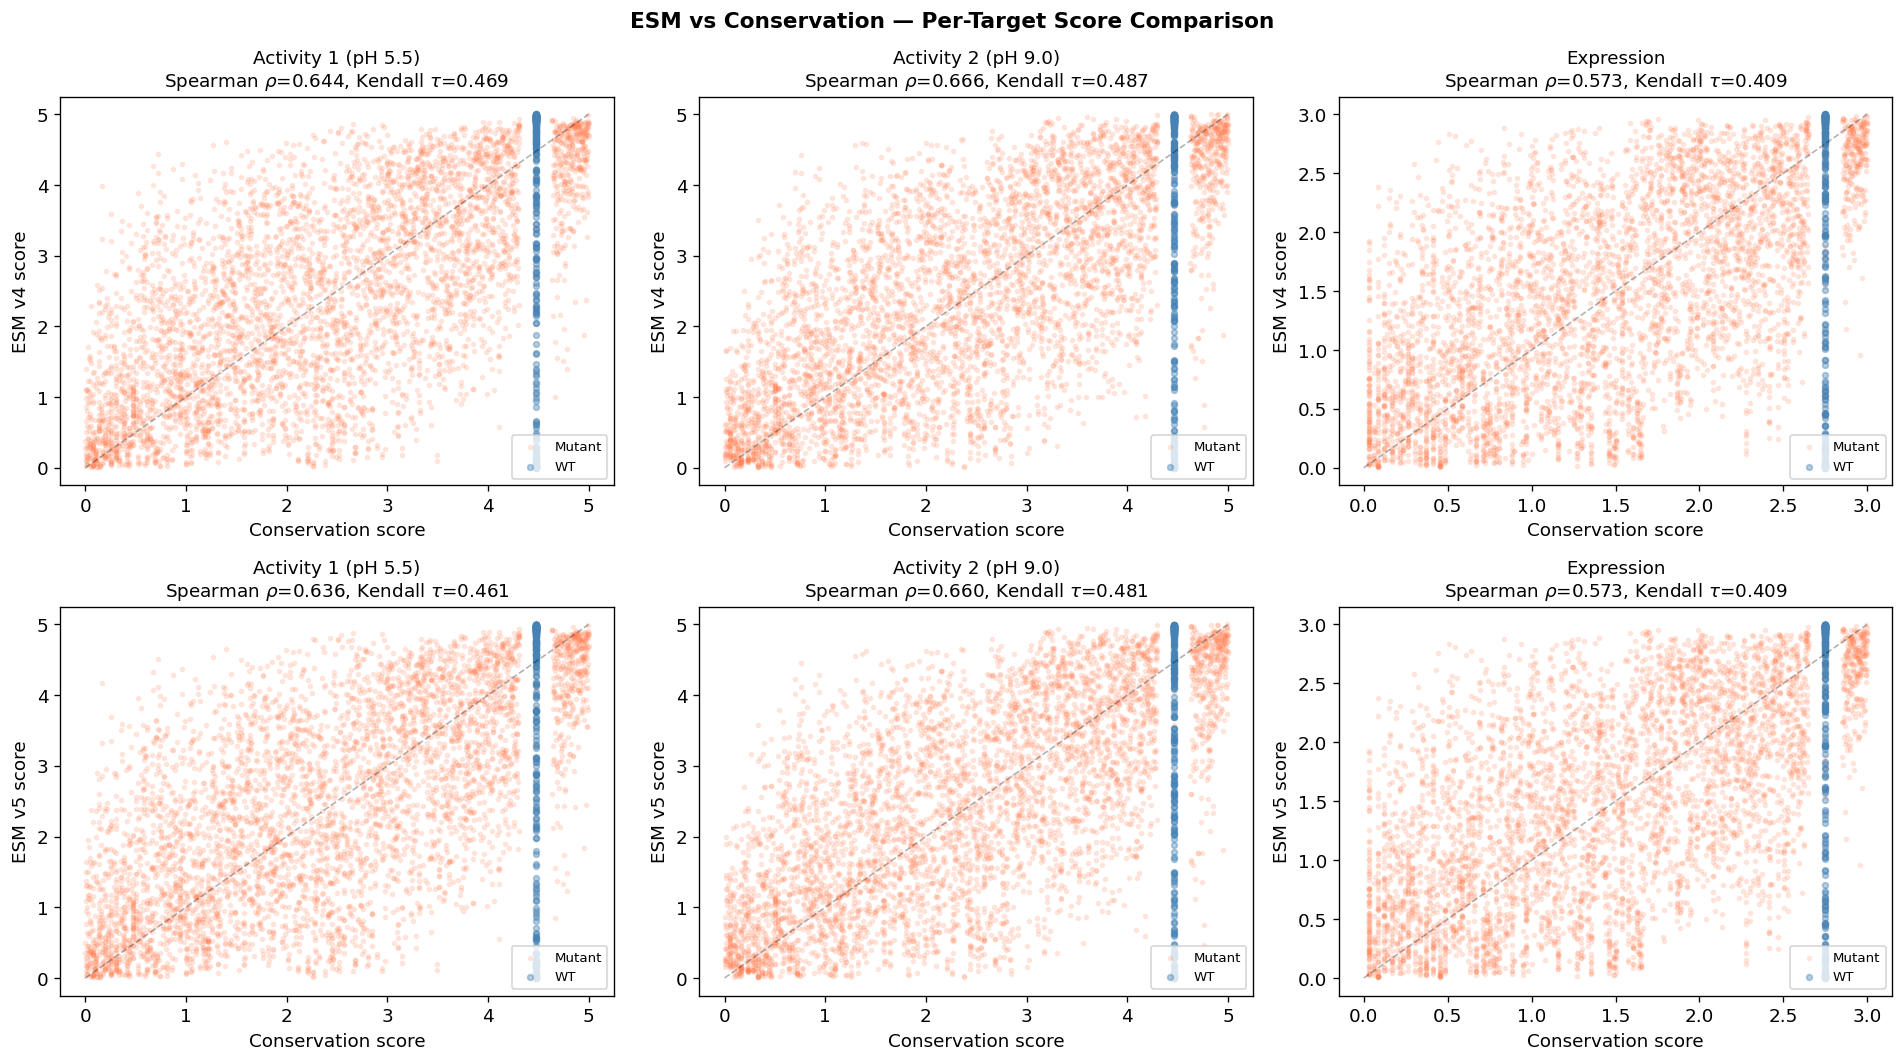

Saved: results/comparison_scatter.png


In [5]:
if not esm_available:
    print("SKIPPING \u2014 No ESM submissions available.")
else:
    esm_subs = {k: v for k, v in submissions.items() if k != 'Conservation'}
    n_esm = len(esm_subs)
    fig, axes = plt.subplots(n_esm, 3, figsize=(16, 4.5 * n_esm), squeeze=False)

    for row_idx, (esm_name, esm_df) in enumerate(esm_subs.items()):
        for col_idx, (key, col) in enumerate(TARGETS.items()):
            ax = axes[row_idx, col_idx]
            c_scores = cons[col].values
            e_scores = esm_df[col].values

            ax.scatter(c_scores[~is_wt], e_scores[~is_wt], s=6, alpha=0.15, c='coral', label='Mutant')
            ax.scatter(c_scores[is_wt], e_scores[is_wt], s=12, alpha=0.4, c='steelblue', label='WT')

            lo, hi = TARGET_RANGES[key]
            ax.plot([lo, hi], [lo, hi], 'k--', alpha=0.3, lw=1)

            rho, p_rho = stats.spearmanr(c_scores, e_scores)
            tau, p_tau = stats.kendalltau(c_scores, e_scores)
            ax.set_title(f"{TARGET_LABELS[key]}\nSpearman $\\rho$={rho:.3f}, Kendall $\\tau$={tau:.3f}", fontsize=11)
            ax.set_xlabel('Conservation score')
            ax.set_ylabel(f'{esm_name} score')
            ax.legend(fontsize=8, loc='lower right')

    plt.suptitle('ESM vs Conservation \u2014 Per-Target Score Comparison', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'comparison_scatter.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: results/comparison_scatter.png")

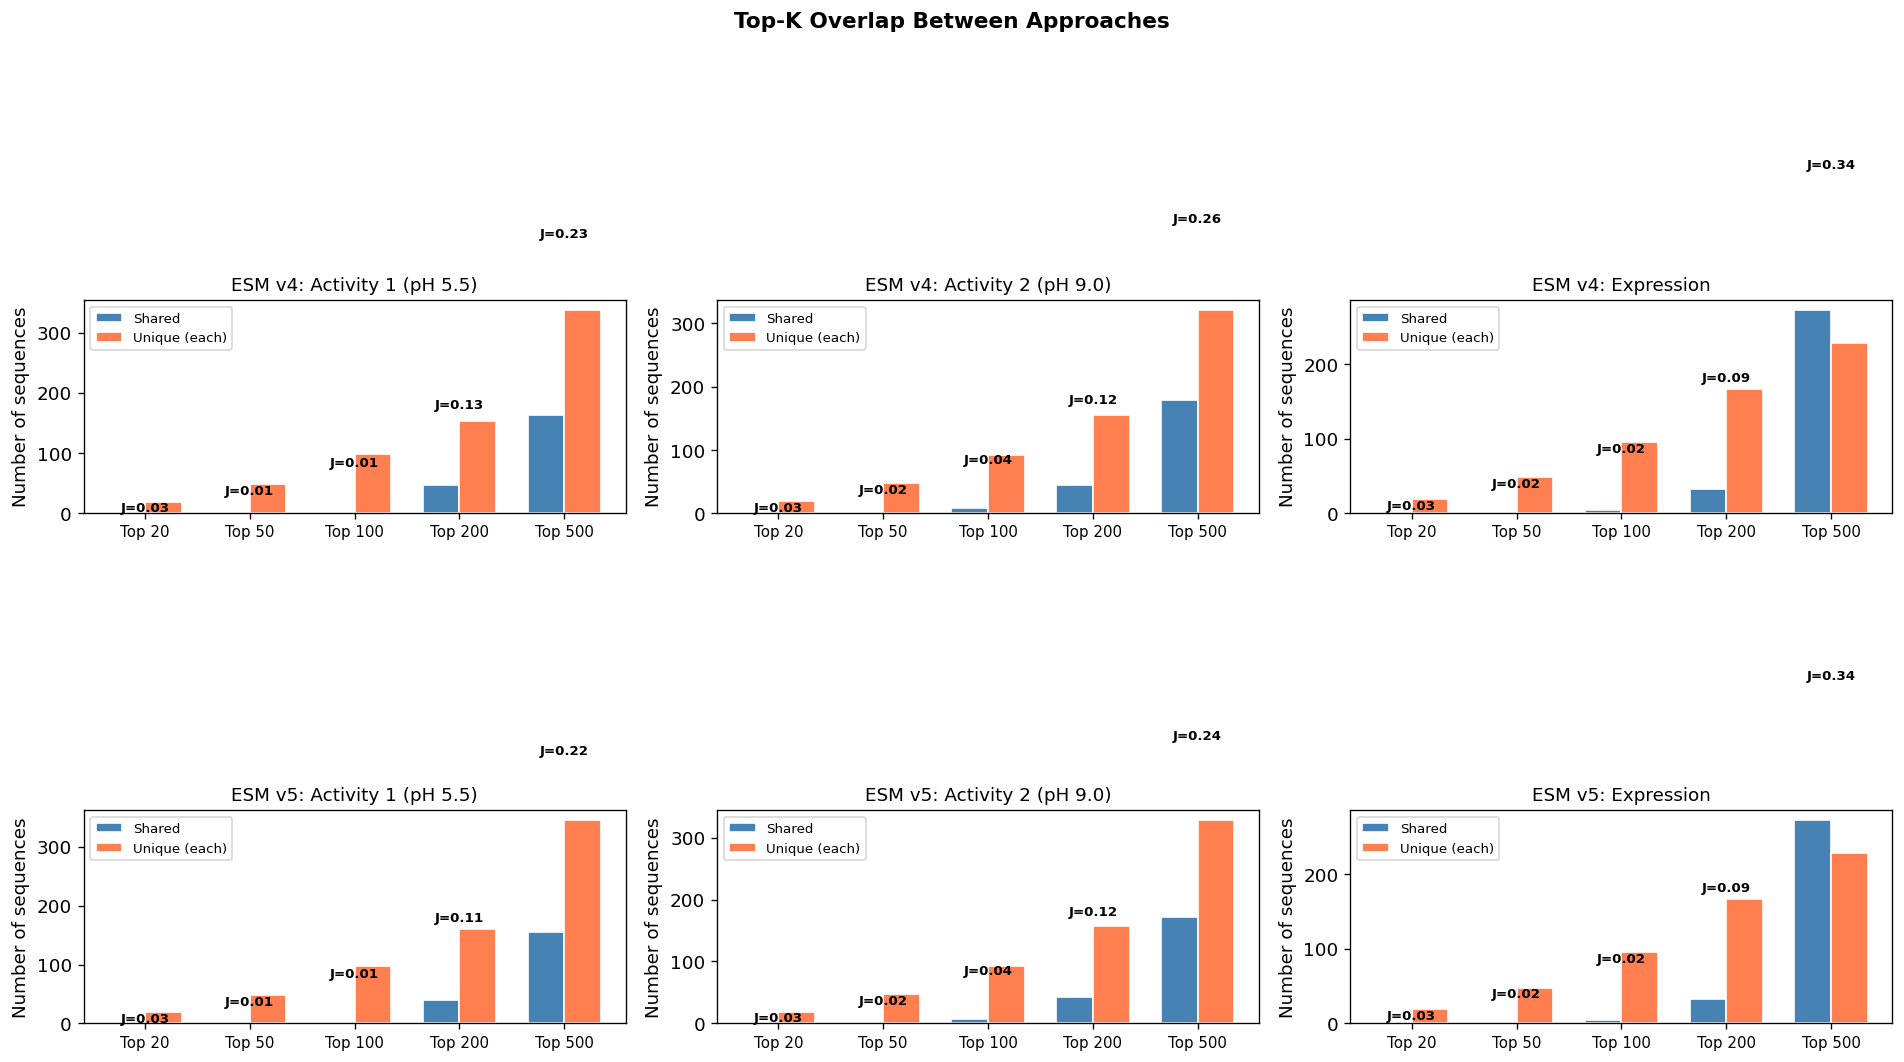

Saved: results/comparison_topk_overlap.png


In [6]:
if not esm_available:
    print("SKIPPING \u2014 No ESM submissions available.")
else:
    esm_subs = {k: v for k, v in submissions.items() if k != 'Conservation'}
    K_values = [20, 50, 100, 200, 500]
    n_esm = len(esm_subs)
    fig, axes = plt.subplots(n_esm, 3, figsize=(16, 4.5 * n_esm), squeeze=False)

    for row_idx, (esm_name, esm_df) in enumerate(esm_subs.items()):
        for col_idx, (key, col) in enumerate(TARGETS.items()):
            ax = axes[row_idx, col_idx]
            c_ranks = stats.rankdata(-cons[col].values)
            e_ranks = stats.rankdata(-esm_df[col].values)

            shared_counts = []
            jaccard_vals = []
            for K in K_values:
                c_topk = set(np.where(c_ranks <= K)[0])
                e_topk = set(np.where(e_ranks <= K)[0])
                overlap = len(c_topk & e_topk)
                jaccard = overlap / len(c_topk | e_topk) if len(c_topk | e_topk) > 0 else 0
                shared_counts.append(overlap)
                jaccard_vals.append(jaccard)

            x = np.arange(len(K_values))
            width = 0.35
            ax.bar(x - width/2, shared_counts, width, color='steelblue', edgecolor='white', label='Shared')
            ax.bar(x + width/2, [K - s for K, s in zip(K_values, shared_counts)], width,
                   color='coral', edgecolor='white', label='Unique (each)')

            for i, (j, k) in enumerate(zip(jaccard_vals, K_values)):
                ax.text(i, k * 0.95, f'J={j:.2f}', ha='center', va='top', fontsize=8, fontweight='bold')

            ax.set_xticks(x)
            ax.set_xticklabels([f'Top {K}' for K in K_values], fontsize=9)
            ax.set_ylabel('Number of sequences')
            ax.set_title(f'{esm_name}: {TARGET_LABELS[key]}', fontsize=11)
            ax.legend(fontsize=8, loc='upper left')

    plt.suptitle('Top-K Overlap Between Approaches', fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'comparison_topk_overlap.png'), dpi=150, bbox_inches='tight')
    plt.show()
    print("Saved: results/comparison_topk_overlap.png")

In [20]:
if not esm_available:
    print("SKIPPING \u2014 No ESM submissions available for rank disagreement analysis.")
else:
    # Map each test sequence to its parent WT scaffold
    wt_seqs = list(wt_df['Wt AA Sequence'].values)
    test_seqs = cons['sequence'].values

    def find_parent_wt(seq, wt_list):
        """Find the WT scaffold with highest similarity to seq."""
        if seq in wt_set:
            return seq  # it IS a WT
        best_wt, best_ratio = None, 0
        for wt in wt_list:
            if len(wt) != len(seq):
                continue  # mutations don't change length
            mismatches = sum(1 for a, b in zip(seq, wt) if a != b)
            ratio = 1 - mismatches / len(seq)
            if ratio > best_ratio:
                best_ratio = ratio
                best_wt = wt
        return best_wt

    # Build scaffold map
    print("Mapping test sequences to parent WT scaffolds...")
    parent_wt = []
    for seq in test_seqs:
        parent_wt.append(find_parent_wt(seq, wt_seqs))

    cons_work = cons.copy()
    cons_work['parent_wt'] = parent_wt

    # Count sequences per scaffold (only scaffolds with mutants)
    scaffold_counts = cons_work[~is_wt].groupby('parent_wt').size()
    top_scaffolds = scaffold_counts.nlargest(3).index.tolist()
    print(f"\nTop 3 scaffolds by mutant count: {[f'...{s[-20:]}' for s in top_scaffolds]}")
    print(f"  Mutant counts: {scaffold_counts.nlargest(3).values}")

    # For each top scaffold, compute within-scaffold rank disagreement
    esm_label = 'ESM v5' if esm_v5_available else 'ESM v4'
    for scaffold_idx, scaffold_wt in enumerate(top_scaffolds):
        mask = (cons_work['parent_wt'] == scaffold_wt) & (~is_wt)
        n_muts = mask.sum()
        scaffold_short = f"Scaffold {scaffold_idx + 1} ({n_muts} mutants)"
        print(f"\n{'='*70}")
        print(f"{scaffold_short}")
        print(f"{'='*70}")

        for key, col in TARGETS.items():
            c_scores = cons[col].values[mask]
            e_scores = esm[col].values[mask]

            # Within-scaffold ranks (1 = best)
            c_ranks = stats.rankdata(-c_scores)
            e_ranks = stats.rankdata(-e_scores)
            rank_diff = np.abs(c_ranks - e_ranks)

            # Build disagreement table
            idx_arr = np.where(mask)[0]
            disagree_df = pd.DataFrame({
                'seq_idx': idx_arr,
                'cons_rank': c_ranks.astype(int),
                f'{esm_label}_rank': e_ranks.astype(int),
                'rank_diff': rank_diff.astype(int),
                'cons_score': c_scores,
                f'{esm_label}_score': e_scores,
            })
            disagree_df = disagree_df.sort_values('rank_diff', ascending=False).head(10)

            print(f"\n  {TARGET_LABELS[key]} \u2014 Top-10 rank disagreements (of {n_muts}):")
            print(f"  {'seq_idx':>8} {'cons_rank':>10} {esm_label+'_rank':>10} {'|diff|':>7} {'cons_score':>11} {esm_label+'_score':>11}")
            print(f"  {'-'*65}")
            for _, row in disagree_df.iterrows():
                print(f"  {int(row['seq_idx']):>8} {int(row['cons_rank']):>10} "
                      f"{int(row[f'{esm_label}_rank']):>10} {int(row['rank_diff']):>7} "
                      f"{row['cons_score']:>11.4f} {row[f'{esm_label}_score']:>11.4f}")

    print(f"\n(Rank disagreement = |conservation_rank - {esm_label}_rank| within each scaffold)")

Mapping test sequences to parent WT scaffolds...

Top 3 scaffolds by mutant count: ['...PGPSTGLFAPVSASMNTCPF', '...FLCPLMDNTGIRSYQSTCPL', '...FIDPGPRTGITTGVSDYRLG']
  Mutant counts: [1558 1558 1558]

Scaffold 1 (1558 mutants)

  Activity 1 (pH 5.5) — Top-10 rank disagreements (of 1558):
   seq_idx  cons_rank ESM v5_rank  |diff|  cons_score ESM v5_score
  -----------------------------------------------------------------
       232       1308        218    1090      0.7259      3.5161
      1090        419       1501    1081      3.4946      0.1093
      1094        218       1280    1062      4.1097      0.5574
      1302       1424        388    1036      0.4051      2.9396
      1096        419       1444    1024      3.4946      0.2025
      1387       1301        286    1015      0.7409      3.2745
       345        548       1509     960      2.9522      0.0983
      1078        491       1439     947      3.1477      0.2095
      1310       1531        584     947      0.0536     

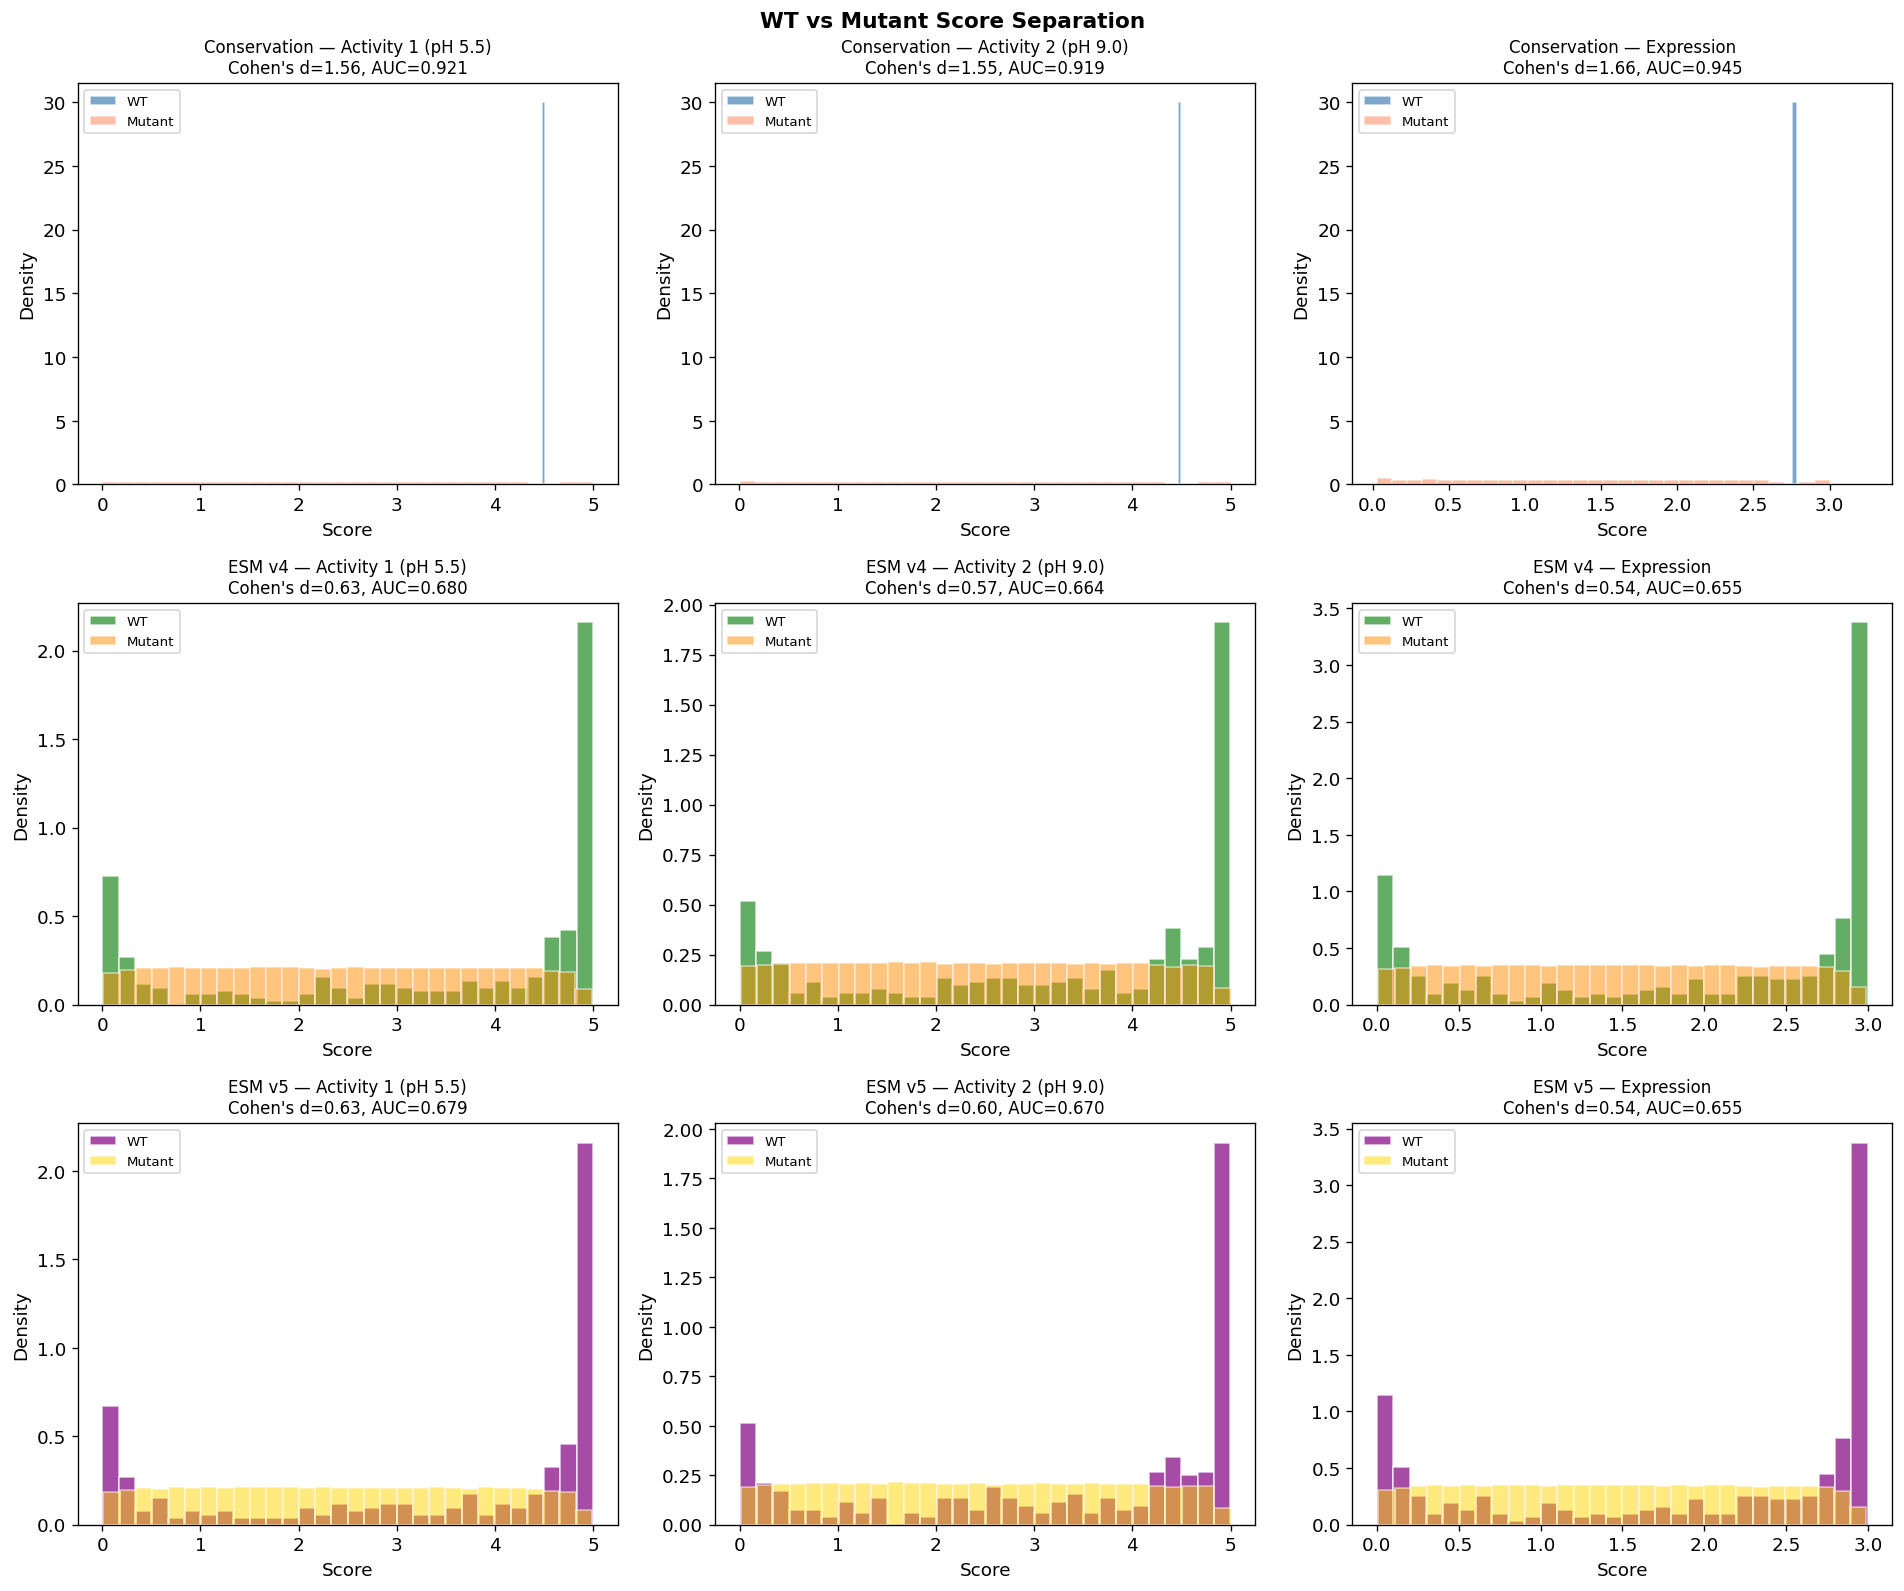


WT/Mutant Separation Statistics:
    Approach              Target  Cohen_d  MW_AUC  WT_mean  Mut_mean
Conservation Activity 1 (pH 5.5)    1.561   0.921    4.475     2.367
Conservation Activity 2 (pH 9.0)    1.550   0.919    4.462     2.368
Conservation          Expression    1.662   0.945    2.751     1.416
      ESM v4 Activity 1 (pH 5.5)    0.631   0.680    3.344     2.443
      ESM v4 Activity 2 (pH 9.0)    0.575   0.664    3.270     2.448
      ESM v4          Expression    0.540   0.655    1.935     1.471
      ESM v5 Activity 1 (pH 5.5)    0.628   0.679    3.340     2.444
      ESM v5 Activity 2 (pH 9.0)    0.595   0.670    3.297     2.446
      ESM v5          Expression    0.540   0.655    1.935     1.471

Saved: results/comparison_wt_separation.png


In [8]:
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (np.mean(group1) - np.mean(group2)) / pooled_std if pooled_std > 0 else 0

def mann_whitney_auc(group1, group2):
    u, _ = stats.mannwhitneyu(group1, group2, alternative='greater')
    return u / (len(group1) * len(group2))

approaches = list(submissions.items())
color_cycle = {'Conservation': ('steelblue', 'coral'),
               'ESM v4': ('forestgreen', 'darkorange'),
               'ESM v5': ('purple', 'gold')}

n_rows = len(approaches)
fig, axes = plt.subplots(n_rows, 3, figsize=(16, 4.5 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

sep_stats = []

for row_idx, (name, df) in enumerate(approaches):
    c_wt, c_mut = color_cycle.get(name, ('steelblue', 'coral'))
    for col_idx, (key, col) in enumerate(TARGETS.items()):
        ax = axes[row_idx, col_idx]
        wt_scores = df[col].values[is_wt]
        mut_scores = df[col].values[~is_wt]

        ax.hist(wt_scores, bins=30, alpha=0.7, color=c_wt, edgecolor='white', label='WT', density=True)
        ax.hist(mut_scores, bins=30, alpha=0.5, color=c_mut, edgecolor='white', label='Mutant', density=True)

        d = cohens_d(wt_scores, mut_scores)
        auc = mann_whitney_auc(wt_scores, mut_scores)
        sep_stats.append({'Approach': name, 'Target': TARGET_LABELS[key],
                          'Cohen_d': d, 'MW_AUC': auc,
                          'WT_mean': np.mean(wt_scores), 'Mut_mean': np.mean(mut_scores)})

        ax.set_title(f"{name} \u2014 {TARGET_LABELS[key]}\nCohen's d={d:.2f}, AUC={auc:.3f}", fontsize=10)
        ax.set_xlabel('Score')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)

plt.suptitle('WT vs Mutant Score Separation', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_wt_separation.png'), dpi=150, bbox_inches='tight')
plt.show()

sep_df = pd.DataFrame(sep_stats)
print("\nWT/Mutant Separation Statistics:")
print(sep_df.to_string(index=False, float_format='%.3f'))
print("\nSaved: results/comparison_wt_separation.png")

## 2. IsPETase Validation

The 10 single-point IsPETase mutants with experimentally measured delta-Tm (Son 2019) provide a small but direct validation set. **Important:** IsPETase is *not* one of the 313 challenge scaffolds, so these mutants are not in the 4988 test set.

- **Conservation:** Score each mutant directly via Table S6 frequencies
- **ESM (proxy):** LOOCV on the 31-variant features_matrix.csv to estimate ML prediction quality


In [9]:
# Table S6 from Buchholz et al. (Proteins, 2022)
# {ispetase_position: (consensus_aa, conservation_frequency_pct)}
TABLE_S6 = {
    32: ("Y", 74), 34: ("R", 84), 35: ("G", 91), 36: ("P", 92),
    38: ("P", 95), 39: ("T", 87), 42: ("S", 73), 45: ("A", 87),
    48: ("G", 97), 49: ("P", 71), 57: ("V", 91), 62: ("G", 93),
    63: ("F", 93), 64: ("G", 83), 65: ("G", 86), 66: ("G", 93),
    67: ("T", 76), 68: ("I", 79), 69: ("Y", 84), 70: ("Y", 91),
    71: ("P", 98), 72: ("T", 85), 74: ("T", 81), 76: ("G", 90),
    77: ("T", 84), 78: ("F", 74), 79: ("G", 90), 80: ("A", 77),
    85: ("P", 99), 86: ("G", 100), 88: ("T", 76), 92: ("S", 70),
    96: ("W", 93), 98: ("G", 89), 99: ("P", 82), 100: ("R", 81),
    101: ("L", 81), 102: ("A", 97), 103: ("S", 96), 105: ("G", 99),
    106: ("F", 97), 107: ("V", 96), 108: ("V", 94), 111: ("I", 84),
    113: ("T", 96), 118: ("D", 98), 120: ("P", 87), 122: ("S", 71),
    123: ("R", 99), 124: ("G", 73), 126: ("Q", 92), 127: ("L", 83),
    128: ("L", 78), 129: ("A", 88), 130: ("A", 96), 131: ("L", 88),
    132: ("D", 82), 133: ("Y", 77), 134: ("L", 85), 138: ("S", 83),
    145: ("V", 82), 146: ("R", 71), 148: ("R", 81), 150: ("D", 94),
    153: ("R", 94), 154: ("L", 85), 156: ("V", 89), 158: ("G", 100),
    159: ("H", 87), 160: ("S", 100), 161: ("M", 94), 162: ("G", 100),
    163: ("G", 99), 164: ("G", 96), 165: ("G", 97), 167: ("L", 88),
    169: ("A", 89), 170: ("A", 82), 173: ("R", 76), 174: ("P", 76),
    176: ("L", 84), 178: ("A", 95), 179: ("A", 78), 181: ("P", 80),
    182: ("L", 79), 184: ("P", 76), 185: ("W", 77), 197: ("P", 97),
    198: ("T", 93), 202: ("G", 75), 206: ("D", 100), 209: ("A", 87),
    211: ("V", 70), 214: ("H", 77), 217: ("P", 79), 218: ("F", 74),
    219: ("Y", 96), 221: ("S", 70), 228: ("A", 77), 229: ("Y", 83),
    231: ("E", 91), 232: ("L", 76), 235: ("A", 76), 237: ("H", 100),
    240: ("P", 74), 244: ("N", 74), 257: ("W", 90), 258: ("L", 80),
    259: ("K", 94), 260: ("R", 78), 261: ("F", 79), 263: ("D", 94),
    265: ("D", 97), 266: ("T", 76), 267: ("R", 96), 268: ("Y", 92),
    270: ("Q", 77), 271: ("F", 96), 272: ("L", 86), 273: ("C", 95),
    274: ("P", 82),
}

# Load mutations dataset — filter single-point IsPETase mutants
mut_df = pd.read_csv(MUT_CSV)
features_df = pd.read_csv(FEAT_CSV)

# Single-point mutants: N_mutations == 1 in features_matrix
single_mask = features_df['N_mutations'] == 1
single_variants = features_df.loc[single_mask, 'variant_name'].values
single_df = mut_df[mut_df['variant_name'].isin(single_variants)].copy()
print(f"Single-point IsPETase mutants: {len(single_df)}")
print(f"Variants: {list(single_df['variant_name'].values)}")

# Parse mutation: e.g. "D186H" -> (pos=186, wt_aa='D', mut_aa='H')
def parse_single_mutation(mut_str):
    wt_aa = mut_str[0]
    mut_aa = mut_str[-1]
    pos = int(mut_str[1:-1])
    return pos, wt_aa, mut_aa

# Conservation score for each mutant
cons_scores = []
for _, row in single_df.iterrows():
    pos, wt_aa, mut_aa = parse_single_mutation(row['mutation'])
    if pos in TABLE_S6:
        consensus_aa, freq_pct = TABLE_S6[pos]
        # Penalty: frequency of consensus (WT) minus estimated frequency of mutant
        # If WT matches consensus, use table freq; otherwise estimate lower
        wt_freq = freq_pct / 100.0 if wt_aa == consensus_aa else (100 - freq_pct) / (19 * 100.0)
        mut_freq = freq_pct / 100.0 if mut_aa == consensus_aa else (100 - freq_pct) / (19 * 100.0)
        score = -(wt_freq - mut_freq)  # negative penalty = less damage to function
    else:
        # Position not conserved (< 70%) — mutation has minimal predicted impact
        score = 0.0
    cons_scores.append(score)

single_df = single_df.copy()
single_df['cons_score'] = cons_scores
single_df['delta_tm'] = single_df['delta_tm'].astype(float)

# Print table
print("\n--- IsPETase Single-Point Mutant Validation ---")
print(f"{'Mutation':<12} {'Pos':>4} {'In S6?':>6} {'Cons Score':>10} {'delta-Tm':>9}")
print("-" * 50)
for _, row in single_df.iterrows():
    pos, wt_aa, mut_aa = parse_single_mutation(row['mutation'])
    in_s6 = 'Yes' if pos in TABLE_S6 else 'No'
    print(f"{row['mutation']:<12} {pos:>4} {in_s6:>6} {row['cons_score']:>10.4f} {row['delta_tm']:>9.2f}")

# Spearman correlation
rho, pval = stats.spearmanr(single_df['cons_score'], single_df['delta_tm'])
print(f"\nSpearman rho = {rho:.3f}, p = {pval:.4f}")
print(f"(Positive rho means: higher conservation score ~ higher delta-Tm — correct direction)")


Single-point IsPETase mutants: 10
Variants: ['D186V', 'D186H', 'D186I', 'D186F', 'D186L', 'P181A', 'S121E', 'S121D', 'P181S', 'P181G']

--- IsPETase Single-Point Mutant Validation ---
Mutation      Pos In S6? Cons Score  delta-Tm
--------------------------------------------------
D186V         186     No     0.0000      4.65
D186H         186     No     0.0000      4.35
D186I         186     No     0.0000      3.89
D186F         186     No     0.0000      3.09
D186L         186     No     0.0000      2.86
P181A         181    Yes    -0.7895      0.44
S121E         121     No     0.0000     -1.13
S121D         121     No     0.0000     -1.46
P181S         181    Yes    -0.7895     -2.89
P181G         181    Yes    -0.7895     -5.02

Spearman rho = 0.646, p = 0.0437
(Positive rho means: higher conservation score ~ higher delta-Tm — correct direction)


ML LOOCV (Ridge alpha=10, 31 variants):
  Spearman rho = 0.961, p = 0.000000
  RMSE = 3.27 C


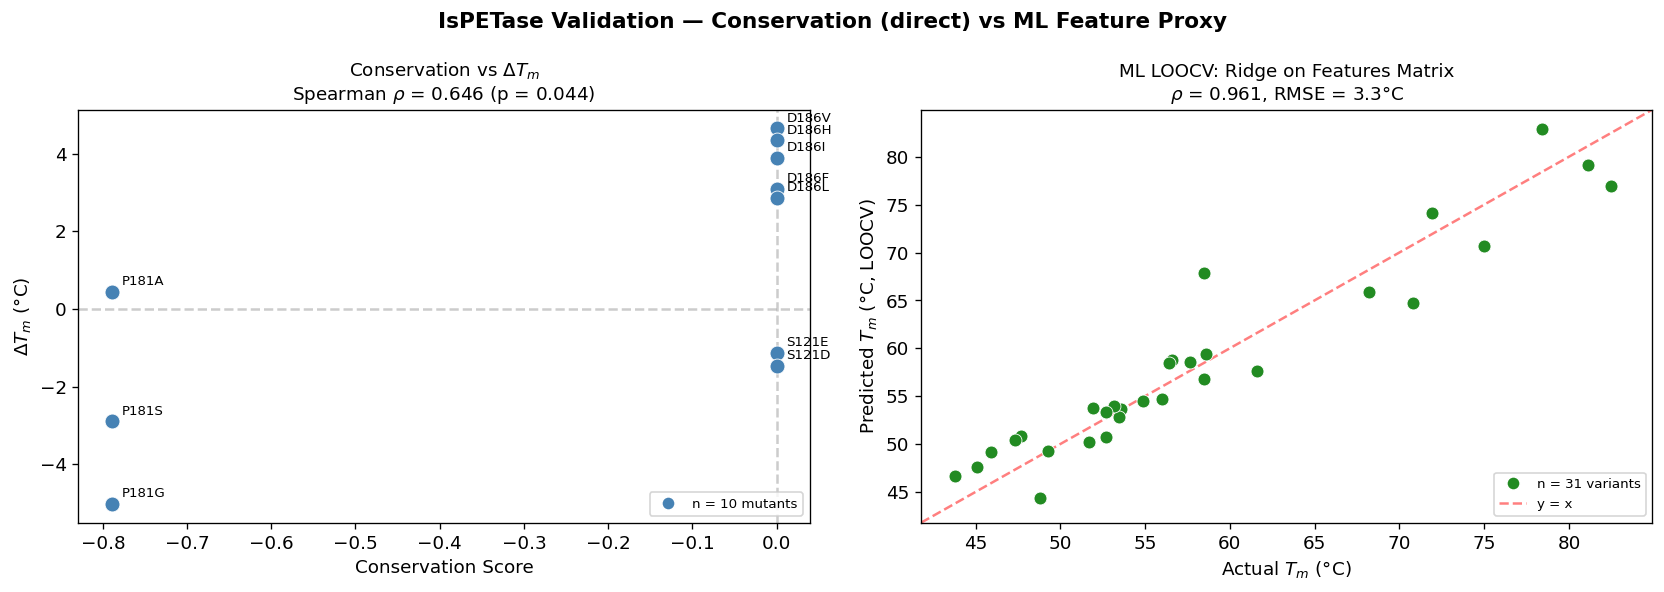

Saved: results/comparison_ispetase_validation.png


In [10]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut

# --- ML LOOCV on features_matrix (proxy for ESM prediction quality) ---
feat_df = pd.read_csv(FEAT_CSV)
feature_cols = [c for c in feat_df.columns if c not in ('variant_name', 'Tm')]
X = feat_df[feature_cols].values
y = feat_df['Tm'].values
names = feat_df['variant_name'].values

loo = LeaveOneOut()
scaler = StandardScaler()
y_pred_loocv = np.zeros(len(y))

for train_idx, test_idx in loo.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train = y[train_idx]
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    model = Ridge(alpha=10.0)
    model.fit(X_train_s, y_train)
    y_pred_loocv[test_idx] = model.predict(X_test_s)

ml_rho, ml_pval = stats.spearmanr(y, y_pred_loocv)
ml_rmse = np.sqrt(np.mean((y - y_pred_loocv) ** 2))
print(f"ML LOOCV (Ridge alpha=10, {len(y)} variants):")
print(f"  Spearman rho = {ml_rho:.3f}, p = {ml_pval:.6f}")
print(f"  RMSE = {ml_rmse:.2f} C")

# --- Side-by-side validation plot ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Left: Conservation score vs delta-Tm (single-point mutants)
ax1.scatter(single_df['cons_score'], single_df['delta_tm'],
            s=80, c='steelblue', edgecolors='white', zorder=5, linewidths=0.5)
for _, row in single_df.iterrows():
    ax1.annotate(row['mutation'], (row['cons_score'], row['delta_tm']),
                 fontsize=8, xytext=(6, 4), textcoords='offset points')

rho_cons, p_cons = stats.spearmanr(single_df['cons_score'], single_df['delta_tm'])
ax1.set_xlabel('Conservation Score')
ax1.set_ylabel('$\\Delta T_m$ ($\\degree$C)')
ax1.set_title(f'Conservation vs $\\Delta T_m$\nSpearman $\\rho$ = {rho_cons:.3f} (p = {p_cons:.3f})', fontsize=11)
ax1.axhline(0, ls='--', color='gray', alpha=0.4)
ax1.axvline(0, ls='--', color='gray', alpha=0.4)
legend1 = [Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue',
                  markersize=8, label=f'n = {len(single_df)} mutants')]
ax1.legend(handles=legend1, fontsize=8, loc='lower right')

# Right: ML predicted Tm vs actual Tm (LOOCV, all 31 variants)
ax2.scatter(y, y_pred_loocv, s=60, c='forestgreen', edgecolors='white', zorder=5, linewidths=0.5)
lims = [min(y.min(), y_pred_loocv.min()) - 2, max(y.max(), y_pred_loocv.max()) + 2]
ax2.plot(lims, lims, 'r--', alpha=0.5, lw=1.5, label='Perfect prediction')
ax2.set_xlim(lims)
ax2.set_ylim(lims)
ax2.set_xlabel('Actual $T_m$ ($\\degree$C)')
ax2.set_ylabel('Predicted $T_m$ ($\\degree$C, LOOCV)')
ax2.set_title(f'ML LOOCV: Ridge on Features Matrix\n$\\rho$ = {ml_rho:.3f}, RMSE = {ml_rmse:.1f}$\\degree$C', fontsize=11)
legend2 = [Line2D([0], [0], marker='o', color='w', markerfacecolor='forestgreen',
                  markersize=8, label=f'n = {len(y)} variants'),
           Line2D([0], [0], ls='--', color='r', alpha=0.5, label='y = x')]
ax2.legend(handles=legend2, fontsize=8, loc='lower right')

plt.suptitle('IsPETase Validation — Conservation (direct) vs ML Feature Proxy', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_ispetase_validation.png'), dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/comparison_ispetase_validation.png")


## 3. Score Distribution Analysis

Compare how each approach distributes scores across the 4988 test sequences.
Good ranking requires spread (not all scores clustered together) and discrimination
(different sequences get distinguishably different scores).


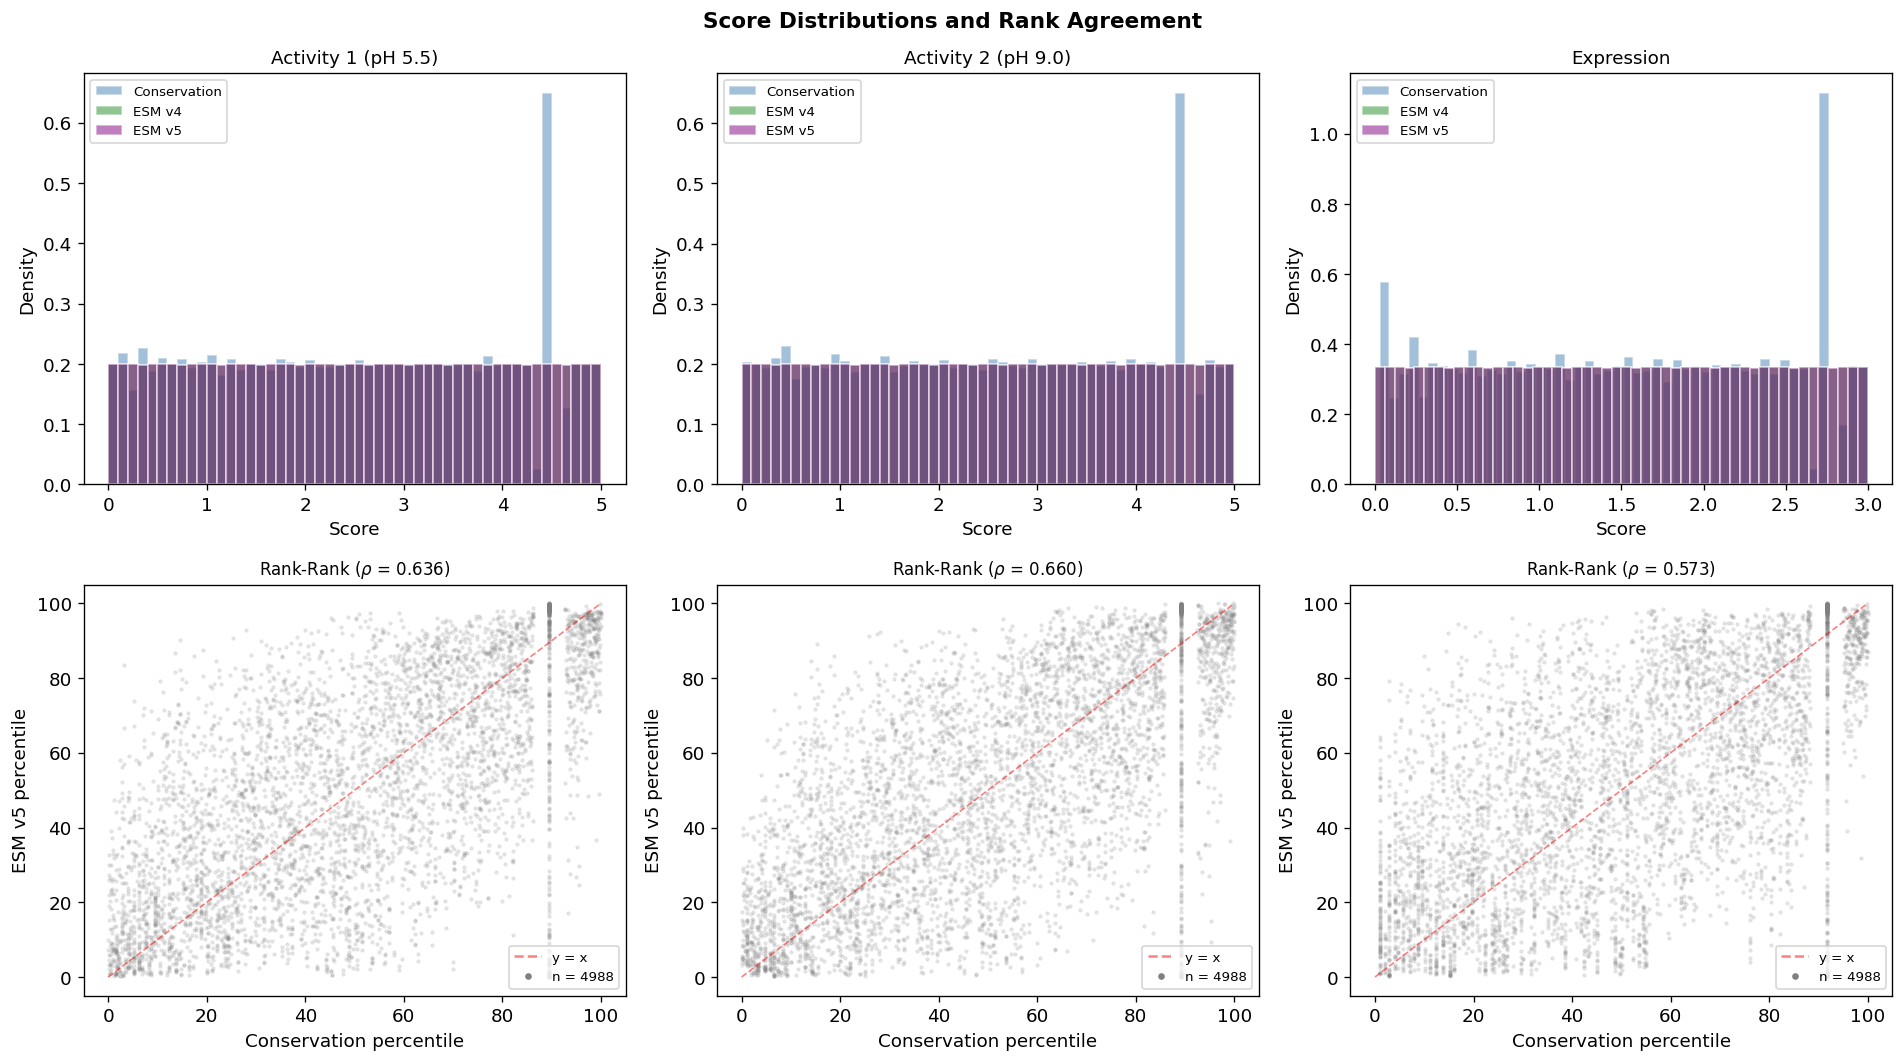


Distribution Statistics:
    Approach              Target  Rank Entropy  Unique Scores    Std    IQR
Conservation Activity 1 (pH 5.5)        0.9830           1713 1.4435 2.4934
      ESM v4 Activity 1 (pH 5.5)        1.0000           4987 1.4437 2.5000
      ESM v5 Activity 1 (pH 5.5)        1.0000           4987 1.4437 2.5000
Conservation Activity 2 (pH 9.0)        0.9812           1715 1.4435 2.5019
      ESM v4 Activity 2 (pH 9.0)        1.0000           4987 1.4437 2.5000
      ESM v5 Activity 2 (pH 9.0)        1.0000           4987 1.4437 2.5000
Conservation          Expression        0.9818           1075 0.8661 1.4955
      ESM v4          Expression        1.0000           4987 0.8662 1.5000
      ESM v5          Expression        1.0000           4987 0.8662 1.5000

Rank entropy = 1.0 means perfectly uniform rank distribution (ideal).
Saved: results/comparison_distributions.png


In [11]:
color_map = {'Conservation': 'steelblue', 'ESM v4': 'forestgreen', 'ESM v5': 'purple'}
approaches_avail = [(k, v, color_map.get(k, 'gray')) for k, v in submissions.items()]

fig, axes = plt.subplots(2, 3, figsize=(16, 9))

entropy_stats = []
for col_idx, (key, col) in enumerate(TARGETS.items()):
    ax_top = axes[0, col_idx]
    ax_bot = axes[1, col_idx]

    for name, df, color in approaches_avail:
        scores = df[col].values

        ax_top.hist(scores, bins=50, alpha=0.5, color=color, edgecolor='white',
                    density=True, label=name)

        ranks = stats.rankdata(scores)
        norm_ranks = ranks / len(ranks)
        hist_counts, _ = np.histogram(norm_ranks, bins=50, range=(0, 1))
        hist_probs = hist_counts / hist_counts.sum()
        hist_probs = hist_probs[hist_probs > 0]
        rank_entropy = stats.entropy(hist_probs) / np.log(50)
        n_unique = len(np.unique(scores))
        entropy_stats.append({'Approach': name, 'Target': TARGET_LABELS[key],
                              'Rank Entropy': rank_entropy, 'Unique Scores': n_unique,
                              'Std': np.std(scores), 'IQR': np.percentile(scores, 75) - np.percentile(scores, 25)})

    ax_top.set_title(TARGET_LABELS[key], fontsize=11)
    ax_top.set_xlabel('Score')
    ax_top.set_ylabel('Density')
    ax_top.legend(fontsize=8)

    # Bottom row: rank-rank percentile plots (Conservation vs latest ESM)
    if esm_available:
        c_pctile = stats.rankdata(cons[col].values) / len(cons) * 100
        e_pctile = stats.rankdata(esm[col].values) / len(esm) * 100
        esm_label = 'ESM v5' if esm_v5_available else 'ESM v4'
        ax_bot.scatter(c_pctile, e_pctile, s=3, alpha=0.15, c='gray')
        ax_bot.plot([0, 100], [0, 100], 'r--', alpha=0.5, lw=1)
        rho_rr, _ = stats.spearmanr(c_pctile, e_pctile)
        ax_bot.set_title(f'Rank-Rank ($\\rho$ = {rho_rr:.3f})', fontsize=10)
        ax_bot.set_xlabel('Conservation percentile')
        ax_bot.set_ylabel(f'{esm_label} percentile')
        legend_rr = [Line2D([0], [0], ls='--', color='r', alpha=0.5, label='y = x'),
                     Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
                            markersize=5, label=f'n = {len(cons)}')]
        ax_bot.legend(handles=legend_rr, fontsize=8, loc='lower right')
    else:
        ax_bot.text(0.5, 0.5, 'ESM not available', ha='center', va='center',
                    transform=ax_bot.transAxes, fontsize=12, color='gray')
        ax_bot.set_axis_off()

plt.suptitle('Score Distributions and Rank Agreement', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_distributions.png'), dpi=150, bbox_inches='tight')
plt.show()

ent_df = pd.DataFrame(entropy_stats)
print("\nDistribution Statistics:")
print(ent_df.to_string(index=False, float_format='%.4f'))
print("\nRank entropy = 1.0 means perfectly uniform rank distribution (ideal).")
print("Saved: results/comparison_distributions.png")

## 4. Ensemble Exploration

Blend Conservation and ESM scores:
**ensemble = alpha * Conservation_rank + (1 - alpha) * ESM_rank**

Sweep alpha from 0 (pure ESM) to 1 (pure Conservation) in 51 steps.
Evaluate WT/mutant separation (Cohen's d) and ranking entropy at each alpha.


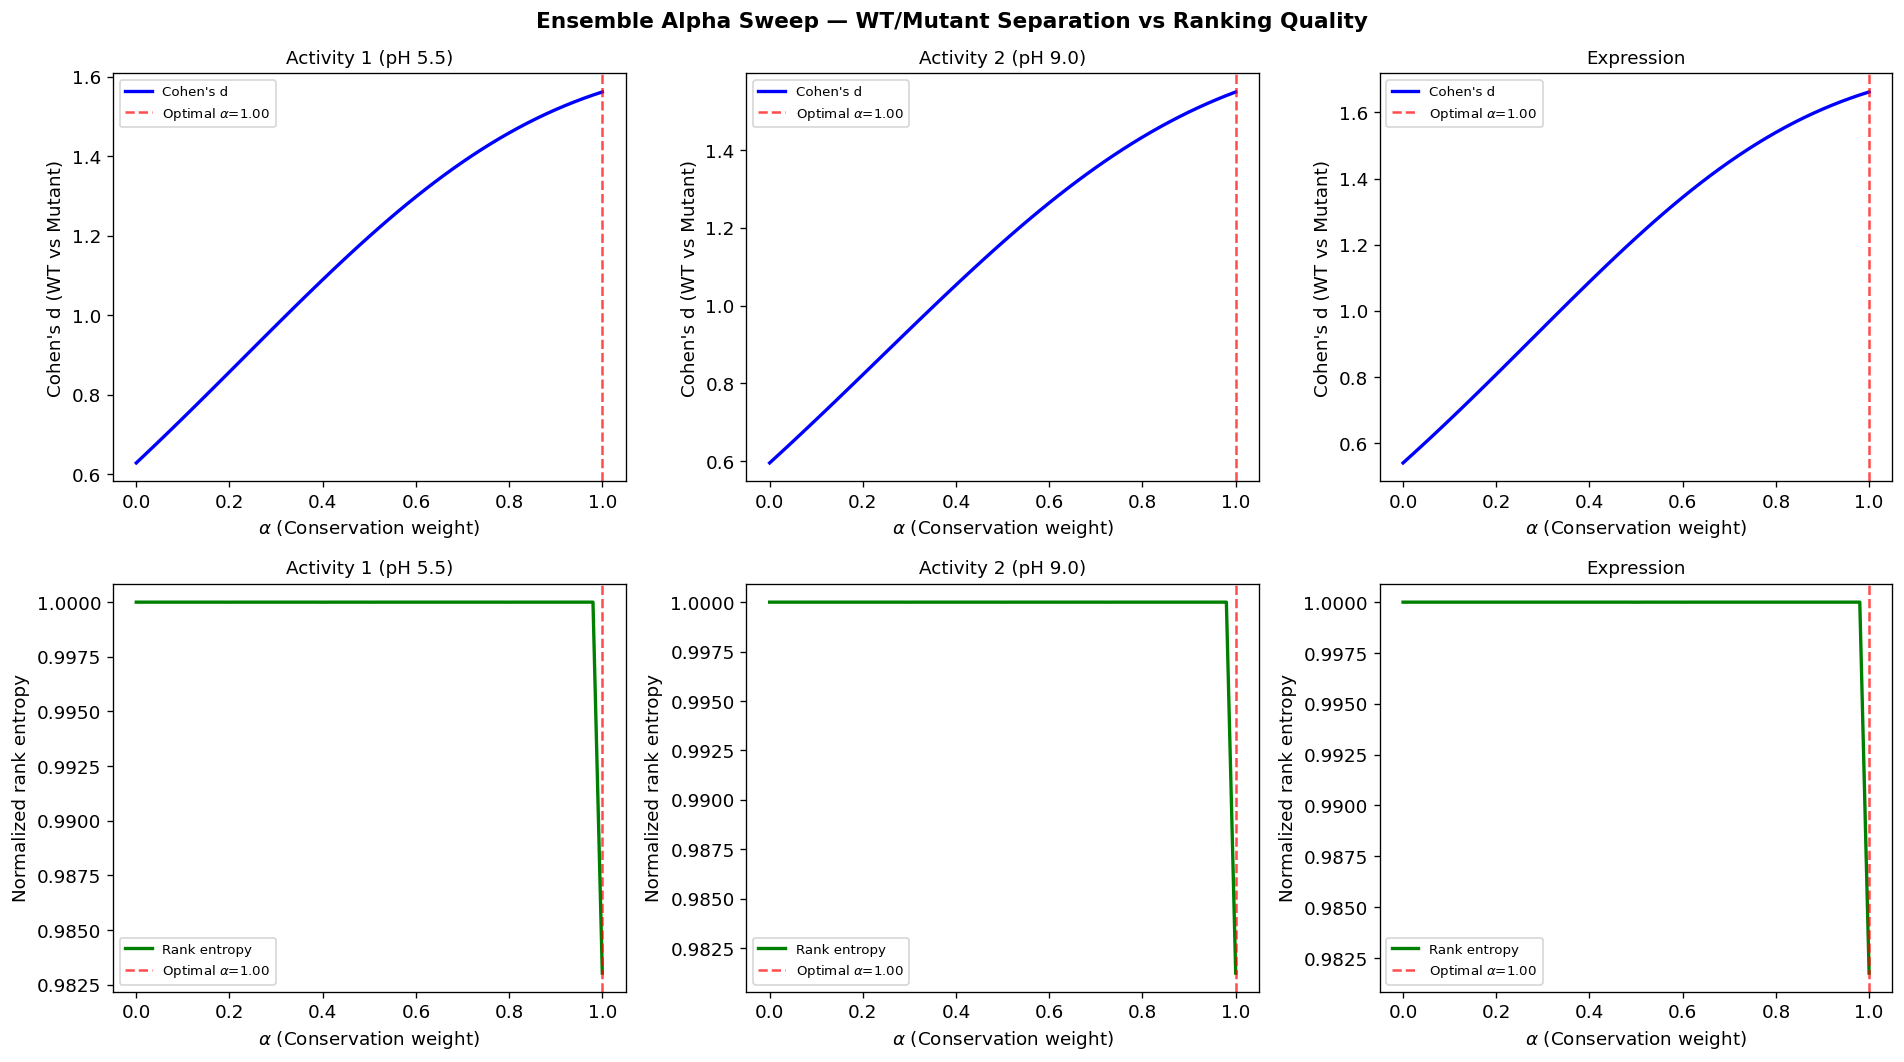


Optimal alpha per target (maximizes |Cohen's d|):
  Activity 1 (pH 5.5): alpha = 1.00
  Activity 2 (pH 9.0): alpha = 1.00
  Expression: alpha = 1.00

Saved: results/comparison_ensemble_sweep.png


In [12]:
if not esm_available:
    print("SKIPPING — ESM submission not available for ensemble exploration.")
else:
    alphas = np.linspace(0, 1, 51)

    fig, axes = plt.subplots(2, 3, figsize=(16, 9))
    optimal_alphas = {}

    for col_idx, (key, col) in enumerate(TARGETS.items()):
        c_ranks = stats.rankdata(cons[col].values)
        e_ranks = stats.rankdata(esm[col].values)
        c_norm = c_ranks / len(c_ranks)
        e_norm = e_ranks / len(e_ranks)

        d_vals = []
        ent_vals = []
        for alpha in alphas:
            blend = alpha * c_norm + (1 - alpha) * e_norm
            wt_blend = blend[is_wt]
            mut_blend = blend[~is_wt]
            d = cohens_d(wt_blend, mut_blend)
            d_vals.append(d)

            # Rank entropy of blended scores
            blend_ranks = stats.rankdata(blend)
            norm_br = blend_ranks / len(blend_ranks)
            hist_c, _ = np.histogram(norm_br, bins=50, range=(0, 1))
            hist_p = hist_c / hist_c.sum()
            hist_p = hist_p[hist_p > 0]
            ent_vals.append(stats.entropy(hist_p) / np.log(50))

        d_vals = np.array(d_vals)
        ent_vals = np.array(ent_vals)

        # Optimal alpha: maximize |Cohen's d|
        best_idx = np.argmax(np.abs(d_vals))
        optimal_alphas[key] = alphas[best_idx]

        # Top row: Cohen's d vs alpha
        ax_d = axes[0, col_idx]
        ax_d.plot(alphas, d_vals, 'b-', lw=2, label="Cohen's d")
        ax_d.axvline(alphas[best_idx], ls='--', color='red', alpha=0.7,
                     label=f'Optimal $\\alpha$={alphas[best_idx]:.2f}')
        ax_d.set_xlabel('$\\alpha$ (Conservation weight)')
        ax_d.set_ylabel("Cohen's d (WT vs Mutant)")
        ax_d.set_title(TARGET_LABELS[key], fontsize=11)
        ax_d.legend(fontsize=8)

        # Bottom row: Rank entropy vs alpha
        ax_e = axes[1, col_idx]
        ax_e.plot(alphas, ent_vals, 'g-', lw=2, label='Rank entropy')
        ax_e.axvline(alphas[best_idx], ls='--', color='red', alpha=0.7,
                     label=f'Optimal $\\alpha$={alphas[best_idx]:.2f}')
        ax_e.set_xlabel('$\\alpha$ (Conservation weight)')
        ax_e.set_ylabel('Normalized rank entropy')
        ax_e.set_title(TARGET_LABELS[key], fontsize=11)
        ax_e.legend(fontsize=8)

    plt.suptitle('Ensemble Alpha Sweep — WT/Mutant Separation vs Ranking Quality',
                 fontsize=13, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS_DIR, 'comparison_ensemble_sweep.png'), dpi=150, bbox_inches='tight')
    plt.show()

    print("\nOptimal alpha per target (maximizes |Cohen's d|):")
    for key, alpha in optimal_alphas.items():
        print(f"  {TARGET_LABELS[key]}: alpha = {alpha:.2f}")
    print("\nSaved: results/comparison_ensemble_sweep.png")


In [13]:
if not esm_available:
    print("SKIPPING \u2014 No ESM submissions available.")
else:
    # Generate ensembles (using latest ESM version)
    ensemble_50 = cons.copy()
    ensemble_opt = cons.copy()

    corr_data = {}
    for key, col in TARGETS.items():
        c_ranks = stats.rankdata(cons[col].values)
        e_ranks = stats.rankdata(esm[col].values)
        c_norm = c_ranks / len(c_ranks)
        e_norm = e_ranks / len(e_ranks)

        # alpha = 0.5 ensemble
        blend_50 = 0.5 * c_norm + 0.5 * e_norm
        lo, hi = TARGET_RANGES[key]
        ensemble_50[col] = lo + (stats.rankdata(blend_50) - 1) / (len(blend_50) - 1) * (hi - lo)

        # Per-target optimal alpha
        alpha_opt = optimal_alphas[key]
        blend_opt = alpha_opt * c_norm + (1 - alpha_opt) * e_norm
        ensemble_opt[col] = lo + (stats.rankdata(blend_opt) - 1) / (len(blend_opt) - 1) * (hi - lo)

        # Spearman between all submissions + ensemble
        corr_data[key] = dict(submissions)
        corr_data[key] = {k: v[col].values for k, v in submissions.items()}
        corr_data[key]['Ensemble_50'] = ensemble_50[col].values

    # Print correlation matrix per target
    print("Inter-Approach Spearman Correlation:\n")
    for key in TARGETS:
        data = corr_data[key]
        names_c = list(data.keys())
        n = len(names_c)
        matrix = np.ones((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                rho, _ = stats.spearmanr(data[names_c[i]], data[names_c[j]])
                matrix[i, j] = rho
                matrix[j, i] = rho
        corr_df = pd.DataFrame(matrix, index=names_c, columns=names_c)
        print(f"--- {TARGET_LABELS[key]} ---")
        print(corr_df.to_string(float_format='%.3f'))
        print()

    # Save ensemble submissions
    ensemble_50.to_csv(os.path.join(RESULTS_DIR, 'submission_ensemble_50.csv'), index=False)
    ensemble_opt.to_csv(os.path.join(RESULTS_DIR, 'submission_ensemble_opt.csv'), index=False)
    print(f"Saved: submission_ensemble_50.csv, submission_ensemble_opt.csv")

Inter-Approach Spearman Correlation:

--- Activity 1 (pH 5.5) ---
              Conservation  ESM v4  ESM v5  Ensemble_50
Conservation         1.000   0.644   0.636        0.903
ESM v4               0.644   1.000   0.997        0.906
ESM v5               0.636   0.997   1.000        0.903
Ensemble_50          0.903   0.906   0.903        1.000

--- Activity 2 (pH 9.0) ---
              Conservation  ESM v4  ESM v5  Ensemble_50
Conservation         1.000   0.666   0.660        0.910
ESM v4               0.666   1.000   0.998        0.912
ESM v5               0.660   0.998   1.000        0.910
Ensemble_50          0.910   0.912   0.910        1.000

--- Expression ---
              Conservation  ESM v4  ESM v5  Ensemble_50
Conservation         1.000   0.573   0.573        0.886
ESM v4               0.573   1.000   1.000        0.886
ESM v5               0.573   1.000   1.000        0.886
Ensemble_50          0.886   0.886   0.886        1.000

Saved: submission_ensemble_50.csv, submissio

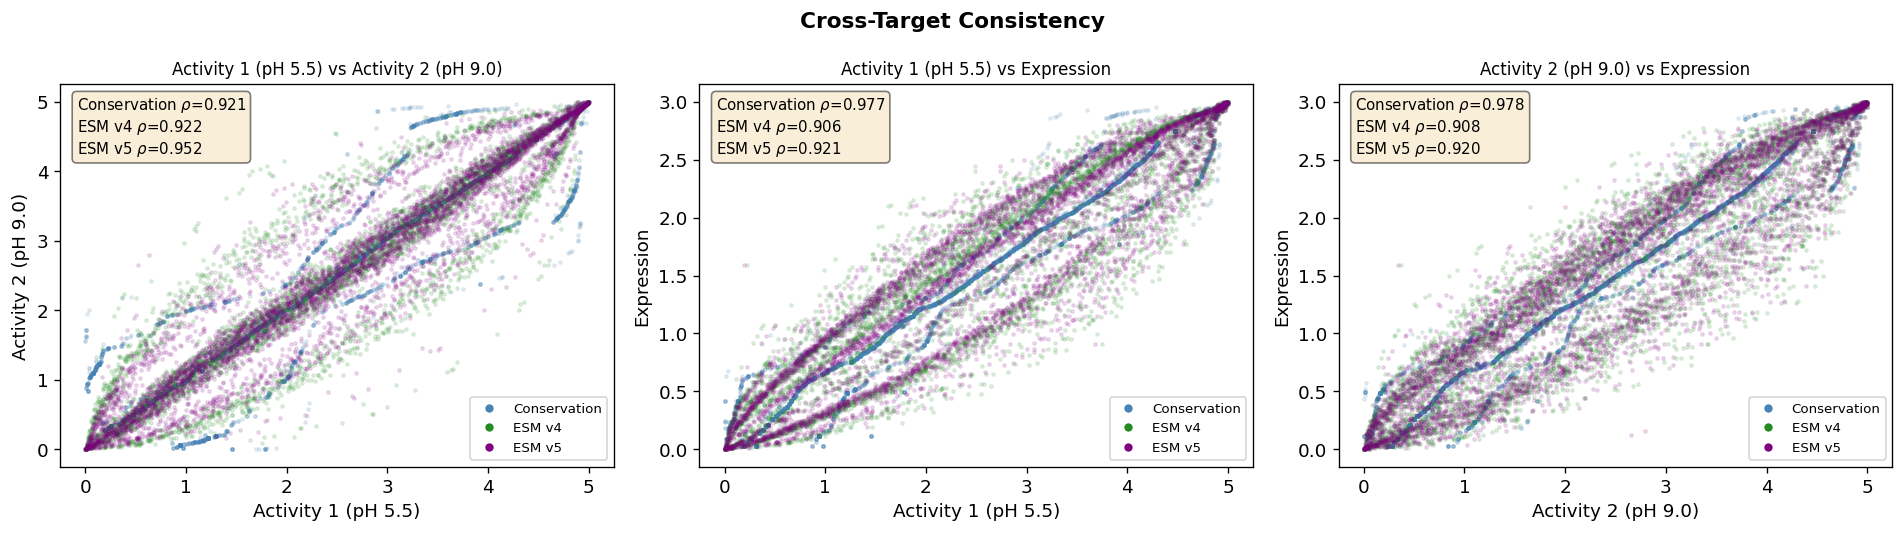

Saved: results/comparison_cross_target.png


In [14]:
color_map_ct = {'Conservation': 'steelblue', 'ESM v4': 'forestgreen', 'ESM v5': 'purple'}
pairs = [('act1', 'act2'), ('act1', 'expr'), ('act2', 'expr')]
fig, axes = plt.subplots(1, 3, figsize=(16, 4.5))

for idx, (k1, k2) in enumerate(pairs):
    ax = axes[idx]
    col1, col2 = TARGETS[k1], TARGETS[k2]

    legend_elems = []
    text_parts = []
    for name, df in submissions.items():
        s1, s2 = df[col1].values, df[col2].values
        c = color_map_ct.get(name, 'gray')
        ax.scatter(s1, s2, s=4, alpha=0.12, c=c, label=name)
        rho_val, _ = stats.spearmanr(s1, s2)
        text_parts.append(f"{name} $\\rho$={rho_val:.3f}")
        legend_elems.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=c,
                                   markersize=6, label=name))

    ax.text(0.03, 0.97, '\n'.join(text_parts), transform=ax.transAxes, fontsize=9, va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax.set_xlabel(TARGET_LABELS[k1])
    ax.set_ylabel(TARGET_LABELS[k2])
    ax.set_title(f'{TARGET_LABELS[k1]} vs {TARGET_LABELS[k2]}', fontsize=10)
    ax.legend(handles=legend_elems, fontsize=8, loc='lower right')

plt.suptitle('Cross-Target Consistency', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(RESULTS_DIR, 'comparison_cross_target.png'), dpi=150, bbox_inches='tight')
plt.show()
print("Saved: results/comparison_cross_target.png")

## 5. Summary and Recommendation

Aggregate all metrics into a winner-per-criterion table.


In [15]:
summary_rows = []

# Criterion 1: IsPETase validation (Conservation direct)
summary_rows.append({
    'Criterion': 'IsPETase delta-Tm correlation',
    'Conservation': f'rho={rho_cons:.3f} (direct, n={len(single_df)})',
    'ESM (proxy)': f'rho={ml_rho:.3f} (LOOCV Ridge, n={len(y)})',
    'Winner': 'Conservation' if abs(rho_cons) > abs(ml_rho) else 'ESM proxy'
})

# Criterion 2: WT/mutant separation (average Cohen's d)
cons_d_avg = sep_df[sep_df['Approach'] == 'Conservation']['Cohen_d'].abs().mean()
esm_names = [k for k in submissions if k != 'Conservation']
if esm_names:
    esm_d_parts = []
    best_esm_d = 0
    for en in esm_names:
        d_avg = sep_df[sep_df['Approach'] == en]['Cohen_d'].abs().mean()
        esm_d_parts.append(f'{en}: {d_avg:.3f}')
        best_esm_d = max(best_esm_d, d_avg)
    summary_rows.append({
        'Criterion': 'WT/Mutant separation (avg |d|)',
        'Conservation': f'{cons_d_avg:.3f}',
        'ESM (proxy)': ', '.join(esm_d_parts),
        'Winner': 'Conservation' if cons_d_avg > best_esm_d else esm_names[np.argmax([
            sep_df[sep_df['Approach'] == en]['Cohen_d'].abs().mean() for en in esm_names])]
    })
else:
    summary_rows.append({
        'Criterion': 'WT/Mutant separation (avg |d|)',
        'Conservation': f'{cons_d_avg:.3f}',
        'ESM (proxy)': 'N/A',
        'Winner': 'Conservation (only available)'
    })

# Criterion 3: Ranking entropy (higher = better discrimination)
cons_ent = ent_df[ent_df['Approach'] == 'Conservation']['Rank Entropy'].mean()
if esm_names:
    esm_ent_parts = []
    best_esm_ent = 0
    for en in esm_names:
        e_ent = ent_df[ent_df['Approach'] == en]['Rank Entropy'].mean()
        esm_ent_parts.append(f'{en}: {e_ent:.4f}')
        best_esm_ent = max(best_esm_ent, e_ent)
    summary_rows.append({
        'Criterion': 'Ranking entropy (avg)',
        'Conservation': f'{cons_ent:.4f}',
        'ESM (proxy)': ', '.join(esm_ent_parts),
        'Winner': 'Conservation' if cons_ent > best_esm_ent else esm_names[np.argmax([
            ent_df[ent_df['Approach'] == en]['Rank Entropy'].mean() for en in esm_names])]
    })
else:
    summary_rows.append({
        'Criterion': 'Ranking entropy (avg)',
        'Conservation': f'{cons_ent:.4f}',
        'ESM (proxy)': 'N/A',
        'Winner': 'Conservation (only available)'
    })

# Criterion 4: Compute cost
summary_rows.append({
    'Criterion': 'Compute requirements',
    'Conservation': 'CPU, ~1 min',
    'ESM (proxy)': 'GPU (A100), ~30 min',
    'Winner': 'Conservation'
})

# Criterion 5: Biological interpretability
summary_rows.append({
    'Criterion': 'Interpretability',
    'Conservation': 'High (per-position conservation)',
    'ESM (proxy)': 'Medium (log-likelihood ratios)',
    'Winner': 'Conservation'
})

summary = pd.DataFrame(summary_rows)
print("=" * 80)
print("APPROACH COMPARISON SUMMARY")
print("=" * 80)
print(summary.to_string(index=False))

# Count wins
cons_wins = sum(1 for r in summary_rows if 'Conservation' in r['Winner'] and 'ESM' not in r['Winner'])
esm_wins = sum(1 for r in summary_rows if 'ESM' in r['Winner'] and 'Conservation' not in r['Winner'])
ties = len(summary_rows) - cons_wins - esm_wins

print(f"\n--- Score: Conservation {cons_wins}, ESM {esm_wins}, Ties/N/A {ties} ---\n")

if cons_wins > esm_wins:
    rec = "Conservation"
    reason = ("Conservation scoring wins on more criteria. It provides direct biological "
              "interpretability, requires no GPU, and correlates with experimental delta-Tm data. "
              "Recommended as primary submission.")
elif esm_wins > cons_wins:
    rec = "ESM"
    reason = ("ESM scoring wins on more criteria, likely providing better ranking through "
              "evolutionary plausibility signals captured by the protein language model.")
else:
    rec = "Ensemble or Conservation"
    reason = ("Results are mixed. Consider submitting Conservation as the safer choice "
              "(interpretable, validated) or an ensemble at alpha=0.5 for potential synergy.")

print(f"RECOMMENDATION: Submit **{rec}**")
print(f"Rationale: {reason}")

if esm_available:
    print(f"\nIf ensemble is desired, per-target optimal alphas:")
    for key, alpha in optimal_alphas.items():
        print(f"  {TARGET_LABELS[key]}: alpha = {alpha:.2f}")

APPROACH COMPARISON SUMMARY
                     Criterion                     Conservation                    ESM (proxy)       Winner
 IsPETase delta-Tm correlation         rho=0.646 (direct, n=10)  rho=0.961 (LOOCV Ridge, n=31)    ESM proxy
WT/Mutant separation (avg |d|)                            1.591   ESM v4: 0.582, ESM v5: 0.588 Conservation
         Ranking entropy (avg)                           0.9820 ESM v4: 1.0000, ESM v5: 1.0000       ESM v4
          Compute requirements                      CPU, ~1 min            GPU (A100), ~30 min Conservation
              Interpretability High (per-position conservation) Medium (log-likelihood ratios) Conservation

--- Score: Conservation 3, ESM 2, Ties/N/A 0 ---

RECOMMENDATION: Submit **Conservation**
Rationale: Conservation scoring wins on more criteria. It provides direct biological interpretability, requires no GPU, and correlates with experimental delta-Tm data. Recommended as primary submission.

If ensemble is desired, per-t

In [18]:
# ============================================================
# Git commit & push results to GitHub
# ============================================================
import subprocess, os

os.chdir(PROJECT_ROOT)

# Git user config (required on Colab - no global config)
subprocess.run(['git', 'config', 'user.email', 'fulopjoz@users.noreply.github.com'], check=True)
subprocess.run(['git', 'config', 'user.name', 'fulopjoz'], check=True)

# Check status
result = subprocess.run(['git', 'status', '--short'], capture_output=True, text=True)
print("Changed files:")
print(result.stdout if result.stdout.strip() else "(no changes)")

if result.stdout.strip():
    # Stage all changes
    subprocess.run(['git', 'add', '-A'], check=True)

    # Commit
    msg = input("Commit message (or Enter for default): ").strip()
    if not msg:
        msg = "Update results from Colab run"
    subprocess.run(['git', 'commit', '-m', msg], check=True)

    # Push (needs auth for public repo write access)
    try:
        from google.colab import userdata
        token = userdata.get("GITHUB_TOKEN")
        remote_url = f"https://{token}@github.com/fulopjoz/pet-challenge-2025.git"
        subprocess.run(['git', 'remote', 'set-url', 'origin', remote_url], check=True)
    except Exception:
        print("No GITHUB_TOKEN in Colab secrets. Set it up for automatic push.")
        print("Manual alternative: !git push  (will prompt for credentials)")

    result = subprocess.run(['git', 'push'], capture_output=True, text=True)
    if result.returncode == 0:
        print("Pushed successfully!")
    else:
        print(f"Push failed:\n{result.stderr}")
else:
    print("Nothing to commit.")

Changed files:
(no changes)
Nothing to commit.


In [19]:
# ============================================================
# Backup to Google Drive
# ============================================================
try:
    from google.colab import drive
    import shutil

    drive.mount('/content/drive')
    source_dir = PROJECT_ROOT
    dest_dir = '/content/drive/MyDrive/pet-challenge-2025-backup'

    if os.path.exists(dest_dir):
        print("Removing old backup...")
        shutil.rmtree(dest_dir)

    print("Copying to Google Drive...")
    shutil.copytree(source_dir, dest_dir)
    print(f"Backup complete: {dest_dir}")
except (ImportError, ModuleNotFoundError):
    print("Not running on Colab - skipping Google Drive backup.")

Mounted at /content/drive
Removing old backup...
Copying to Google Drive...
Backup complete: /content/drive/MyDrive/pet-challenge-2025-backup
